# 1.  Numerical Methods for Solving the Heat Equation and Image Diffusion
In this section, we look at the implementations of the heat equation to diffuse the MNIST dataset.

We will first look at the Finite Difference Method, which will consist of the forward and Backward Euler method. 

After this, we look at the Finite Element Method. We will look at the implementation of the quadrilateral and triangular elements. 


## 1.1 Finite Difference Methods 


### 1.1.1 Forward Euler Finite Difference Method 

In this implementation, we code the forward Euler scheme on the heat equation with homogeneous boundary conditions. 

Loaded MNIST digit: 5
Running diffusion simulation...
Simulation completed in 0.19 seconds
Visualizing results...


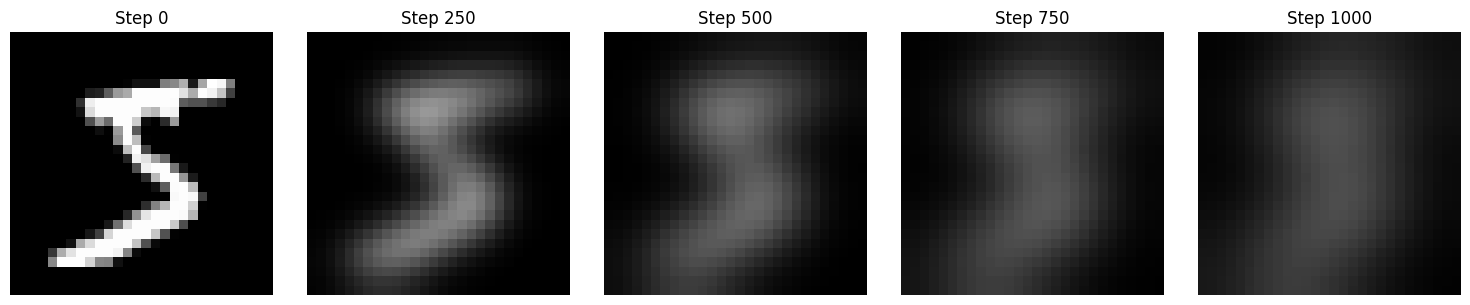

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
import time

class ForwardEuler: 
    def __init__(self, alpha=0.1, dx=1.0, dy=1.0): 
        self.alpha = alpha
        self.dx = dx
        self.dy = dy
        
    def forward_euler_diffuse(self, image, alpha=0.1, num_steps=50, dt=0.1):
        """
        Diffuse an image using the heat equation with explicit finite differences
        
        Parameters:
        - image: 2D numpy array (input image)
        - alpha: diffusion coefficient
        - num_steps: number of time steps
        - dt: time step size
        
        Returns:
        - diffused_images: list of images at different time steps
        """
        u = image.copy().astype(np.float64)
        diffused_images = [u.copy()]
        
        # Stability check as this method is conditionally stable
        stability_condition = alpha * dt * (1/self.dx**2 + 1/self.dy**2)
        if stability_condition > 0.5:
            print(f"Warning: Stability condition: {stability_condition:.3f}")
        
        for step in range(num_steps):
            laplacian = np.zeros_like(u)
            
            # Interior points (standard 5-point stencil)
            laplacian[1:-1, 1:-1] = ( (u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1]) / self.dx**2 + (u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2]) / self.dy**2)
            
            # Boundary points with second-order Neumann BCs
            # Top boundary (i=0): uses ghost cell u[-1,j] = u[1,j]
            laplacian[0, 1:-1] = ((u[1, 1:-1] - 2*u[0, 1:-1] + u[1, 1:-1]) / self.dx**2 + (u[0, 2:] - 2*u[0, 1:-1] + u[0, :-2]) / self.dy**2)
            
            # Bottom boundary (i=-1): uses ghost cell u[N,j] = u[N-2,j]  
            laplacian[-1, 1:-1] = ((u[-2, 1:-1] - 2*u[-1, 1:-1] + u[-2, 1:-1]) / self.dx**2 +  (u[-1, 2:] - 2*u[-1, 1:-1] + u[-1, :-2]) / self.dy**2)
            
            # Left boundary (j=0): uses ghost cell u[i,-1] = u[i,1]
            laplacian[1:-1, 0] = ((u[2:, 0] - 2*u[1:-1, 0] + u[:-2, 0]) / self.dx**2 +(u[1:-1, 1] - 2*u[1:-1, 0] + u[1:-1, 1]) / self.dy**2 )
            
            # Right boundary (j=-1): uses ghost cell u[i,N] = u[i,N-2]
            laplacian[1:-1, -1] = ((u[2:, -1] - 2*u[1:-1, -1] + u[:-2, -1]) / self.dx**2 + (u[1:-1, -2] - 2*u[1:-1, -1] + u[1:-1, -2]) / self.dy**2 )
            
            # Corners (use average of adjacent approaches)
            # Top-left (0,0)
            laplacian[0, 0] = ((u[1, 0] - 2*u[0, 0] + u[1, 0]) / self.dx**2 +(u[0, 1] - 2*u[0, 0] + u[0, 1]) / self.dy**2)
            
            # Top-right (0,-1)
            laplacian[0, -1] = ((u[1, -1] - 2*u[0, -1] + u[1, -1]) / self.dx**2 +(u[0, -2] - 2*u[0, -1] + u[0, -2]) / self.dy**2)
            
            # Bottom-left (-1,0)
            laplacian[-1, 0] = ((u[-2, 0] - 2*u[-1, 0] + u[-2, 0]) / self.dx**2 +(u[-1, 1] - 2*u[-1, 0] + u[-1, 1]) / self.dy**2)
            
            # Bottom-right (-1,-1)
            laplacian[-1, -1] = ((u[-2, -1] - 2*u[-1, -1] + u[-2, -1]) / self.dx**2 + (u[-1, -2] - 2*u[-1, -1] + u[-1, -2]) / self.dy**2)
            
            # Update using explicit Euler
            u += alpha * dt * laplacian
            diffused_images.append(u.copy())

        return diffused_images

# Load the dataset using torchvision
def load_mnist_image(index=0):
    """Load a single MNIST image"""
    transform = transforms.ToTensor()
    mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    image, label = mnist_dataset[index]
    return image.squeeze().numpy(), label

# Example usage
if __name__ == "__main__":
    # Load MNIST image
    image, label = load_mnist_image(index=0)  # Try different indices
    print(f"Loaded MNIST digit: {label}")

    heat_eq = ForwardEuler(alpha=0.1, dx=1.0, dy=1.0)
    
    print("Running diffusion simulation...")
    start_time = time.time() 
    results = heat_eq.forward_euler_diffuse(image, alpha=0.1, num_steps=1000, dt=0.1)
    end_time = time.time()

    print(f"Simulation completed in {end_time - start_time:.2f} seconds")

    # Visualize results
    print(f"Visualizing results...")
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    time_indices = [0, len(results)//4, len(results)//2, 
                    3*len(results)//4, len(results)-1]
    
    for idx, ax in enumerate(axes.flat):
        if idx < len(time_indices):
            time_idx = time_indices[idx]
            ax.imshow(results[time_idx], cmap='gray', vmin=0, vmax=1)
            ax.set_title(f'Step {time_idx}')
            ax.axis('off')
    
    plt.tight_layout()
    #plt.suptitle('MNIST Image Diffusion using Heat Equation', y=1.10)
    plt.show()

### 1.1.2 Backward Euler Finite Difference Method

In this implementation, we code the forward Euler scheme on the heat equation with homogeneous boundary conditions. 

Loaded MNIST digit: 5
Running diffusion simulation...
Simulation completed in 2.00 seconds.
Visualizing results...


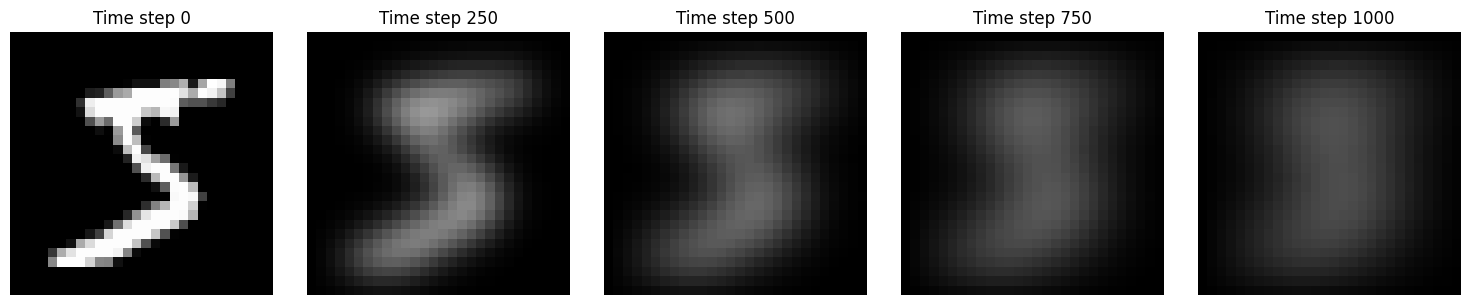

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, eye
from scipy.sparse.linalg import spsolve
import torch
import torchvision
import time 
from torchvision import datasets, transforms

class BackwardEuler:
    """
        Diffuse an image using the heat equation with implicit finite differences
        
        Parameters:
        - image: 2D numpy array (input image)
        - alpha: diffusion coefficient
        - num_steps: number of time steps
        - dt: time step size
        
        Returns:
        - results: list of images at different time steps
        """
    def __init__(self, alpha=0.1, dx=1.0, dy=1.0):
        self.alpha = alpha
        self.dx = dx
        self.dy = dy
    
    def create_laplacian_matrix(self, nx, ny):
        """Create the discrete Laplacian matrix with Neumann boundary conditions"""
        N = nx * ny
        # Main diagonal: -4 for interior points
        main_diag = -2 * (1/self.dx**2 + 1/self.dy**2) * np.ones(N)
        
        # x-direction neighbors (left and right)
        x_diag = (1/self.dx**2) * np.ones(N)
        # Remove connections at boundaries in x-direction
        for i in range(ny):
            x_diag[i * nx] = 0  # Left boundary
            x_diag[i * nx + nx - 1] = 0  # Right boundary
        
        # y-direction neighbors (above and below)
        y_diag = (1/self.dy**2) * np.ones(N)
        # Remove connections at boundaries in y-direction
        for i in range(nx):
            y_diag[i] = 0  # Top boundary
            y_diag[(ny - 1) * nx + i] = 0  # Bottom boundary
        
        # Create the sparse matrix
        diagonals = [main_diag, x_diag, x_diag, y_diag, y_diag]
        offsets = [0, -1, 1, -nx, nx]
        
        A = diags(diagonals, offsets, shape=(N, N), format='csr')
        return A
    
    def backward_euler_step(self, u, dt, A):
        """Perform one Backward Euler step"""
        N = u.size
        I = eye(N, format='csr')
        
        # Solve (I - α*dt*A) u^{n+1} = u^n
        lhs_matrix = I - self.alpha * dt * A
        u_flat = u.flatten()
        
        # Solve the linear system
        u_new_flat = spsolve(lhs_matrix, u_flat)
        u_new = u_new_flat.reshape(u.shape)
        
        return u_new
    
    def diffuse_image(self, u0, dt, num_steps):
        """Diffuse the initial image over time"""
        ny, nx = u0.shape
        A = self.create_laplacian_matrix(nx, ny)
        
        u = u0.copy()
        results = [u.copy()]
        
        for step in range(num_steps):
            u = self.backward_euler_step(u, dt, A)
            results.append(u.copy())
        
        return np.array(results)

def load_mnist_image(index=0):
    """Load and preprocess an MNIST image"""
    transform = transforms.ToTensor()
    test_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    image, label = test_dataset[index]
     
    return image.squeeze().numpy(), label

def visualize_results(initial_image, diffused_images, timesteps_to_show=None):
    """Visualize the diffusion process"""
    if timesteps_to_show is None:
        timesteps_to_show = [0, len(diffused_images)//4, len(diffused_images)//2, 
                           3*len(diffused_images)//4, len(diffused_images)-1]
    
    n_plots = len(timesteps_to_show)
    fig, axes = plt.subplots(1, n_plots, figsize=(15, 3))
    
    if n_plots == 1:
        axes = [axes]
    
    for i, timestep in enumerate(timesteps_to_show):
        axes[i].imshow(diffused_images[timestep], cmap='gray', vmin=0, vmax=1)
        axes[i].set_title(f'Time step {timestep}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


# Main execution
if __name__ == "__main__":
    # Parameters
    alpha = 0.1        # Diffusion coefficient
    dt = 0.1           # Time step
    num_steps = 1000   # Number of time steps
    
    # Load MNIST image
    initial_image, label = load_mnist_image()
    print(f"Loaded MNIST digit: {label}")
    
    # Initialize heat equation solver
    heat_eq = BackwardEuler(alpha=alpha)
   
    # Perform diffusion
    print("Running diffusion simulation...")
    start_time = time.time()
    results = heat_eq.diffuse_image(initial_image, dt, num_steps)
    end_time = time.time()

    print(f"Simulation completed in {end_time - start_time:.2f} seconds.")
    
    # Visualize results
    print("Visualizing results...")
    visualize_results(initial_image, results)
    

## 1.2 Finite Element Method

### 1.2.1 Quadrilateral elements

In this part, we look at the implementation of the finite element method with quadrilateral elements. 

Loading MNIST sample...
Loaded MNIST digit: 5
Preprocessing image...
Initializing FEM solver...
Initial condition size: 1024, FEM nodes: 1024
Running diffusion simulation...
Simulation completed in 0.04 seconds


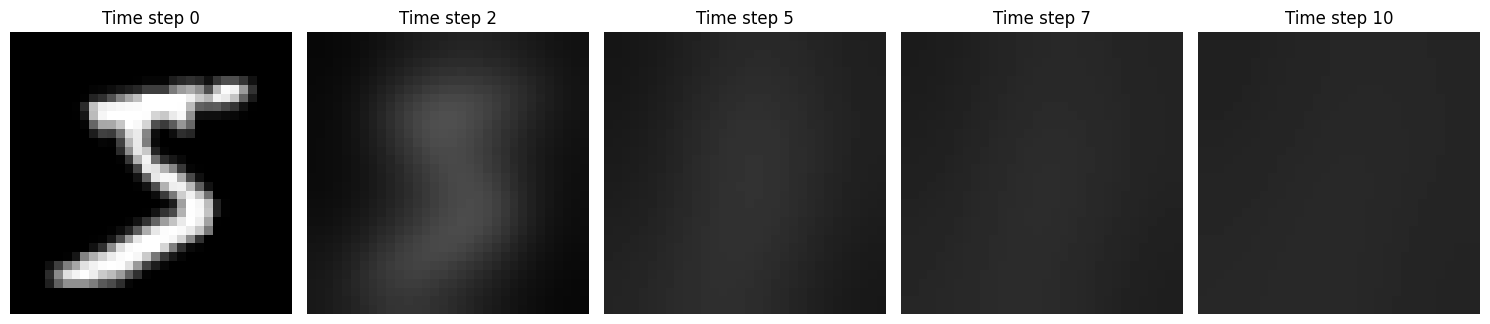

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import torchvision
from scipy import sparse
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
import time 
import os
from datetime import datetime 

class QuadElementFEM: 
    def __init__(self, nx, ny, Lx=1.0, Ly=1.0): 
        self.nx = nx 
        self.ny = ny 
        self.Lx = Lx 
        self.Ly = Ly 
        self.dx = Lx / nx 
        self.dy = Ly / ny
        self.n_nodes = (nx + 1) * (ny + 1)

        # 2x2 Gauss quadrature points and weights
        self.gauss_points = np.array([
            [-1/np.sqrt(3), -1/np.sqrt(3)], 
            [1/np.sqrt(3), -1/np.sqrt(3)], 
            [1/np.sqrt(3), 1/np.sqrt(3)], 
            [-1/np.sqrt(3), 1/np.sqrt(3)]  
        ])
        self.gauss_weights = np.ones(4)

        self._assemble_system()

    def basis_functions(self, xi, eta): 
        """ 
        Create the basis functions. 

        xi, eta: local variables 
        """
        N = np.array([
            0.25 * (1 - xi) * (1 - eta),
            0.25 * (1 + xi) * (1 - eta),
            0.25 * (1 + xi) * (1 + eta), 
            0.25 * (1 - xi) * (1 + eta)
        ])
        return N
    
    def basis_derivatives(self, xi, eta):
        """
        Create the derivatives of the basis functions.
        
        xi, eta: local variables
        """ 
        dN_dxi = np.array([
            -0.25 * (1 - eta), 0.25 * (1 - eta), 0.25 * (1 + eta), -0.25 * (1 + eta)
        ])
        dN_deta = np.array([
            -0.25 * (1 - xi), -0.25 * (1 + xi), 0.25 * (1 + xi), 0.25 * (1 - xi)
        ])
        return dN_dxi, dN_deta
    
    def jacobian(self, nodes, xi, eta): 
        dN_dxi, dN_deta = self.basis_derivatives(xi, eta)

        dx_dxi = np.dot(dN_dxi, nodes[:, 0])
        dx_deta = np.dot(dN_deta, nodes[:, 0])
        dy_dxi = np.dot(dN_dxi, nodes[:, 1])
        dy_deta = np.dot(dN_deta, nodes[:, 1])

        J = np.array([[dx_dxi, dx_deta], 
                      [dy_dxi, dy_deta]])
        
        detJ = np.linalg.det(J)
        return J, detJ
    
    def _assemble_system(self): 
        self.K = lil_matrix((self.n_nodes, self.n_nodes))
        self.M = lil_matrix((self.n_nodes, self.n_nodes))

        for i in range(self.nx): 
            for j in range(self.ny): 
                node0 = j * (self.nx + 1) + i                   # left upper corner  
                node1 = j * (self.nx + 1) + i + 1               # right upper corner
                node2 = (j + 1) * (self.nx + 1) + i + 1         # right bottom corner  
                node3 = (j + 1) * (self.nx + 1) + i             # left bottom corner
                nodes = np.array([node0, node1, node2, node3])  # The four corners of each element

                coords = np.array([
                    [i * self.dx, j * self.dy], 
                    [(i + 1) * self.dx, j * self.dy], 
                    [(i + 1) * self.dx, (j + 1) * self.dy],
                    [i * self.dx, (j + 1) * self.dy]
                ])                                              # coordinates of the four corners of the element in the global domain on [0, Lx] x [0, Ly]

                Ke = np.zeros((4, 4))                           # Initialize element stiffness matrix
                Me = np.zeros((4, 4))                           # Initialize element mass matrix

                for gp, (xi, eta) in enumerate(self.gauss_points): 
                    weight = self.gauss_weights[gp]
                    N = self.basis_functions(xi, eta)
                    dN_dxi, dN_deta = self.basis_derivatives(xi, eta)

                    J, detJ = self.jacobian(coords, xi, eta)

                    if detJ <= 1e-12:
                        print(f"Warning: Small or negative Jacobian at element ({i},{j})")
                        continue

                    invJ = np.linalg.inv(J)

                    # Derivatives in global coordinates 
                    dN_dx = invJ[0,0] * dN_dxi + invJ[0, 1] * dN_deta
                    dN_dy = invJ[1, 0] * dN_dxi + invJ[1, 1] * dN_deta

                    for a in range(4): 
                        for b in range(4): 
                            Ke[a, b] += (dN_dx[a] * dN_dx[b] + dN_dy[a] * dN_dy[b]) * detJ * weight
                            Me[a, b] += N[a] * N[b] * detJ * weight

                for a, node_a in enumerate(nodes): 
                    for b, node_b in enumerate(nodes): 
                        self.K[node_a, node_b] += Ke[a, b]
                        self.M[node_a, node_b] += Me[a, b]

        self.K = self.K.tocsr() 
        self.M = self.M.tocsr()

    def diffuse(self, u0, dt, n_steps, diffusion_coeff=1.0):
        """
        Diffuse initial condition using Backward Euler method
        """
        u = u0.copy()

        # System matrix for Backward Euler in time and finite element method space
        A = self.M + diffusion_coeff * dt * self.K

        results = [u.reshape(self.ny + 1, self.nx + 1)]

        for step in range(n_steps):
            # Right-hand side
            b = self.M.dot(u)
            
            u = spsolve(A, b)
            
            results.append(u.reshape(self.ny + 1, self.nx + 1))

        return np.array(results)

def load_mnist_sample(index=0): 
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((32,32))
    ])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    image, label = trainset[index]
    image_np = image.squeeze().numpy()
    return image_np, label


def main(): 
    # Parameters 
    nx, ny = 31, 31  # If we have 31 elements we have 32 nodes, which matches MNIST
    dt = 0.1
    n_steps = 10
    diffusion_coeff = 0.1 

    print("Loading MNIST sample...")
    mnist_image, label = load_mnist_sample() 
    print(f"Loaded MNIST digit: {label}")

    print("Preprocessing image...")
    initial_condition = (mnist_image - mnist_image.min()) / (mnist_image.max() - mnist_image.min() + 1e-8)

    # Create FEM solver 
    print("Initializing FEM solver...")
    fem_solver = QuadElementFEM(nx, ny, Lx=1.0, Ly=1.0)

    # Flatten initial condition 
    u0 = initial_condition.flatten()
    
    # Check if sizes match
    print(f"Initial condition size: {len(u0)}, FEM nodes: {fem_solver.n_nodes}")
    
    if len(u0) != fem_solver.n_nodes: 
        print("Warning: Size mismatch, truncating...")
        u0 = u0[fem_solver.n_nodes]
    
    print("Running diffusion simulation...")
    start_time = time.time() 
    results = fem_solver.diffuse(u0, dt, n_steps, diffusion_coeff)
    end_time = time.time()

    print(f"Simulation completed in {end_time - start_time:.2f} seconds")


    # Visualization
    fig, axes = plt.subplots(1, 5, figsize=(15, 10))
    time_indices = [0, n_steps//4, n_steps//2, 3*n_steps//4, n_steps]

    for i, idx in enumerate(time_indices): 
        axes[i].imshow(results[idx], cmap='gray', vmin=0, vmax=1)
        axes[i].set_title(f'Time step {idx}')
        axes[i].axis('off')

    plt.tight_layout() 
    plt.show()

if __name__ == "__main__": 
    main()



### 1.2.2 Triangular Elements

In this part, we implement the finite element method on triangular elements. Since the first method, already works really well, this is an idea as to how to code it. It does not work very well on our problem.
The focus will be on the quadrilateral elements after this code. 

Converged at step 6


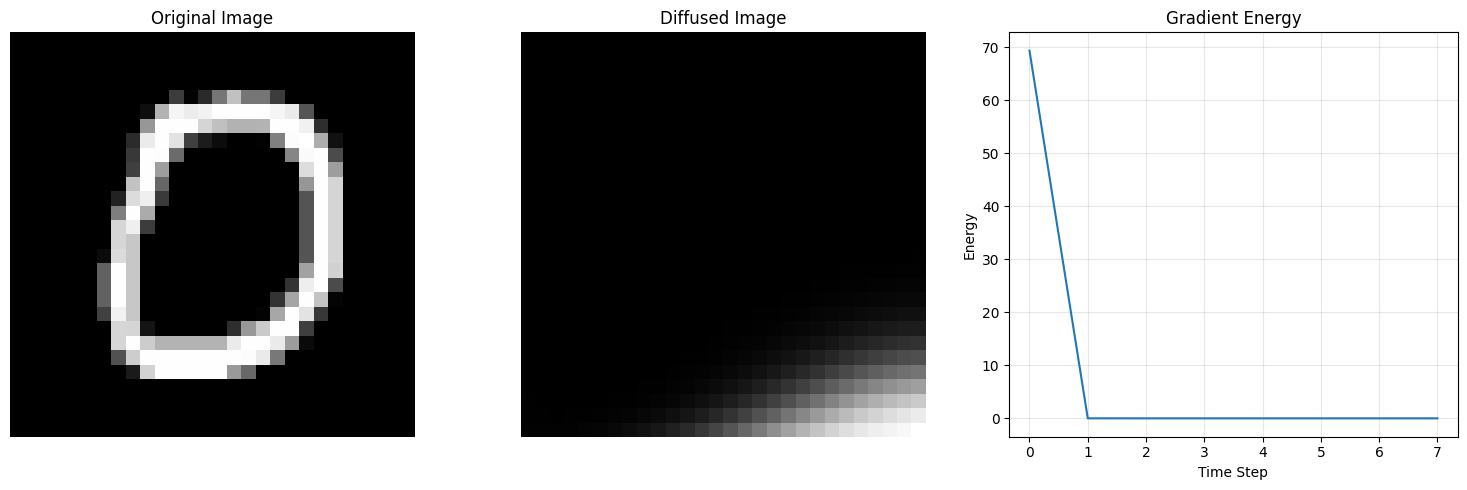

Initial energy: 69.382
Final energy: 0.000
Energy reduction: 7032837532738274304.00


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve

class P1FEMDiffusion:
    """
    Simplified P1 Finite Element Method for image diffusion
    """
    
    def __init__(self, dt=0.1, steps=50):
        self.dt = dt
        self.steps = steps
        self._assembled = False
        
    def load_image(self, image):
        self.original_image = image.astype(float)
        self.nx, self.ny = self.original_image.shape
        self.N = self.nx * self.ny
        self.u = self.original_image.flatten().copy()
        
        self.hx = 1.0 / (self.nx - 1)
        self.hy = 1.0 / (self.ny - 1)
        self._assembled = False
        
    def _index_map(self, i, j):
        return i * self.ny + j
    
    def _create_mesh(self):
        self.coords = np.array([[i * self.hx, j * self.hy] 
                               for i in range(self.nx) for j in range(self.ny)])
        
        self.triangles = []
        for i in range(self.nx - 1): 
            for j in range(self.ny - 1): 
                n0 = self._index_map(i, j)
                n1 = self._index_map(i + 1, j)
                n2 = self._index_map(i, j + 1)
                n3 = self._index_map(i + 1, j + 1)
                self.triangles.append([n0, n1, n2])
                self.triangles.append([n1, n3, n2])
    
    def _assemble_matrices(self):
        if self._assembled:
            return
            
        self._create_mesh()
        
        K = lil_matrix((self.N, self.N)) 
        M = lil_matrix((self.N, self.N))
        
        for tri in self.triangles: 
            nodes = np.array([self.coords[i] for i in tri])
            
            v1 = nodes[1] - nodes[0]
            v2 = nodes[2] - nodes[0]
            area = 0.5 * np.abs(v1[0] * v2[1] - v1[1] * v2[0])
            
            mat = np.ones((3, 3))
            mat[:, 1:] = nodes 
            grads = np.linalg.inv(mat)[:, 1:]
            
            Ke = area * grads @ grads.T
            Me = (area / 12.0) * (np.ones((3, 3)) + np.eye(3))
            
            for a in range(3): 
                for b in range(3): 
                    K[tri[a], tri[b]] += Ke[a, b]
                    M[tri[a], tri[b]] += Me[a, b]
        
        self.K = K.tocsr()
        self.M = M.tocsr()
        self._assembled = True
    
    def _calculate_gradient_energy(self, u_array):
        u_img = u_array.reshape((self.nx, self.ny))
        grad_x = np.diff(u_img, axis=0)
        grad_y = np.diff(u_img, axis=1)
        return np.sum(grad_x**2) + np.sum(grad_y**2)
    
    def solve(self, convergence_tol=1e-6):
        if not self._assembled:
            self._assemble_matrices()
        
        # Store initial energy
        self.initial_energy = self._calculate_gradient_energy(self.u)
        self.energies = [self.initial_energy]
        
        for step in range(self.steps):
            A = self.M + self.dt * self.K
            b = self.M @ self.u
            
            u_new = spsolve(A, b)
            
            energy = self._calculate_gradient_energy(u_new)
            self.energies.append(energy)
            
            diff_norm = np.linalg.norm(u_new - self.u)
            self.u = u_new
            
            if diff_norm < convergence_tol:
                print(f"Converged at step {step}")
                break
        
        self.final_energy = energy
        return self.get_solution()
    
    def get_solution(self):
        return self.u.reshape((self.nx, self.ny))
    
    def plot_comparison(self):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image
        axes[0].imshow(self.original_image, cmap='gray')
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        # Diffused image
        diffused = self.get_solution()
        axes[1].imshow(diffused, cmap='gray')#, vmin=0, vmax=1)
        axes[1].set_title("Diffused Image")
        axes[1].axis('off')
        
        # Energy plot
        axes[2].plot(self.energies)
        axes[2].set_title("Gradient Energy")
        axes[2].set_xlabel("Time Step")
        axes[2].set_ylabel("Energy")
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print energy information
        print(f"Initial energy: {self.initial_energy:.3f}")
        print(f"Final energy: {self.final_energy:.3f}")
        print(f"Energy reduction: {self.initial_energy/self.final_energy:.2f}")


# Example usage
if __name__ == "__main__":
    from torchvision.datasets import MNIST
    from torchvision import transforms
    
    # Load MNIST digit
    mnist = MNIST(root='.', train=False, download=True, transform=transforms.ToTensor())
    digit_tensor, _ = mnist[10]
    digit = digit_tensor.squeeze().numpy()
    
    # Create and run diffusion
    solver = P1FEMDiffusion(dt=0.1, steps=50)
    solver.load_image(digit)
    diffused = solver.solve()
    
    # Show results
    solver.plot_comparison()

# 2. Prepare the Data

In this section we prepare the data and set up the device. 

We will load in the data in dataloaders and create a balanced subsest of the data, to test the initial model. 

First of all, we import the necessary packages and define the device. The device means that the code will run on a GPU if there is a GPU available, if not it will run on the CPU.


In [25]:
import torch 
from torch import nn, optim 
import torch.nn.functional as F 
from torchvision import datasets, transforms 
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
import numpy as np 
import matplotlib.pyplot as plt 
import time


torch.backends.cudnn.benchmark = True 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In this code we create the training and test dataloaders from the MNIST dataset, using the datasets of PyTorch.


In [8]:
def mnist_data_loader(): 
    # Load the data 
    train_data = datasets.MNIST(root="data", train=True, download=False, transform=transforms.Compose([transforms.Resize((32, 32)), ToTensor()]))
    test_data = datasets.MNIST(root="data", train=False, download=False, transform=transforms.Compose([transforms.Resize((32, 32)), ToTensor()]))

    # Create class names and class name to index mapping for MNIST 
    class_names = train_data.classes 
    class_names_to_idx = train_data.class_to_idx

    # Create data loaders 
    BATCH_SIZE = 32 
    train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
    return train_data, test_data, train_dataloader, test_dataloader, BATCH_SIZE


We create the balanced subset of the MNIST dataset. 

In [ ]:
from collections import defaultdict

def create_balanced_subset(dataset, samples_per_class=50, seed=42):
    """
    Create a balanced subset with equal samples per class
    """
    torch.manual_seed(seed)
    class_indices = defaultdict(list)
    
    # Group indices by class
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        class_indices[label].append(idx)
    
    # Select balanced samples
    selected_indices = []
    for class_idx in range(10):  # 0-9 for MNIST
        class_samples = class_indices[class_idx]
        if len(class_samples) > samples_per_class:
            selected = torch.randperm(len(class_samples))[:samples_per_class]
            selected_indices.extend([class_samples[i] for i in selected])
        else:
            selected_indices.extend(class_samples)
    
    return torch.utils.data.Subset(dataset, selected_indices)


To actually create the dataloaders, the complete or the balanced subset, we run the next part of code.

In [11]:
train_data, test_data, train_dataloader, test_dataloader, BATCH_SIZE = mnist_data_loader()

# Balanced subset with 50 samples per class (500 total)
balanced_subset = create_balanced_subset(train_data, samples_per_class=50)
balanced_test_subset = create_balanced_subset(test_data, samples_per_class=50)
balanced_dataloader = DataLoader(balanced_subset, batch_size=BATCH_SIZE, shuffle=True)
balanced_test_dataloader = DataLoader(balanced_test_subset, batch_size=BATCH_SIZE, shuffle=False)

# 3. Create the first Neural Network

In this part, we will create the first U-Net and its training and testing loop.

## 3.1 The U-Net

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x): 
        return self.conv(x)

class U_net1(nn.Module): 
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128]): 
        super().__init__()
        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder part  
        for feature in features: 
            self.encoder.append(ConvBlock(in_channels, feature))
            in_channels = feature

        # Bottleneck part 
        self.bottleneck = ConvBlock(features[-1], features[-1]*2)

        # Decoder part 
        self.upconvs = nn.ModuleList()
        self.decoder = nn.ModuleList()

        reversed_features = features[::-1]
        for feature in reversed_features: 
            self.upconvs.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.decoder.append(ConvBlock(feature*2, feature))
        
        # Final convolution 
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x): 
        skip_connections = []
        for encode in self.encoder: 
            x = encode(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(len(self.upconvs)): 
            x = self.upconvs[idx](x)
            skip_connection = skip_connections[idx]
            if x.shape != skip_connection.shape: 
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True) # We resize x to have the same shape as skip_connection as this is more common in concatenation skip connections
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx](concat_skip)
        return self.final_conv(x)

## 3.2 Create the training and test loop

Batch:0, Loss: 0.1003
  X range: [0.000, 1.000]
  X_noisy range: [0.048, 0.250]
  Pred range: [-0.012, -0.003]
Epoch 1/60, Training Loss: 0.0876
Test Loss: 0.0845
Batch:0, Loss: 0.0729
  X range: [0.000, 1.000]
  X_noisy range: [0.044, 0.220]
  Pred range: [0.034, 0.091]
Epoch 2/60, Training Loss: 0.0818
Test Loss: 0.0807
Batch:0, Loss: 0.0876
  X range: [0.000, 1.000]
  X_noisy range: [0.047, 0.272]
  Pred range: [0.036, 0.198]
Epoch 3/60, Training Loss: 0.0776
Test Loss: 0.0741
Batch:0, Loss: 0.0777
  X range: [0.000, 1.000]
  X_noisy range: [0.057, 0.273]
  Pred range: [-0.020, 0.308]
Epoch 4/60, Training Loss: 0.0712
Test Loss: 0.0630
Batch:0, Loss: 0.0669
  X range: [0.000, 1.000]
  X_noisy range: [0.055, 0.366]
  Pred range: [-0.075, 0.439]
Epoch 5/60, Training Loss: 0.0582
Test Loss: 0.0541
Batch:0, Loss: 0.0495
  X range: [0.000, 1.000]
  X_noisy range: [0.041, 0.249]
  Pred range: [-0.032, 0.558]
Epoch 6/60, Training Loss: 0.0537
Test Loss: 0.0528
Batch:0, Loss: 0.0517
  X ran

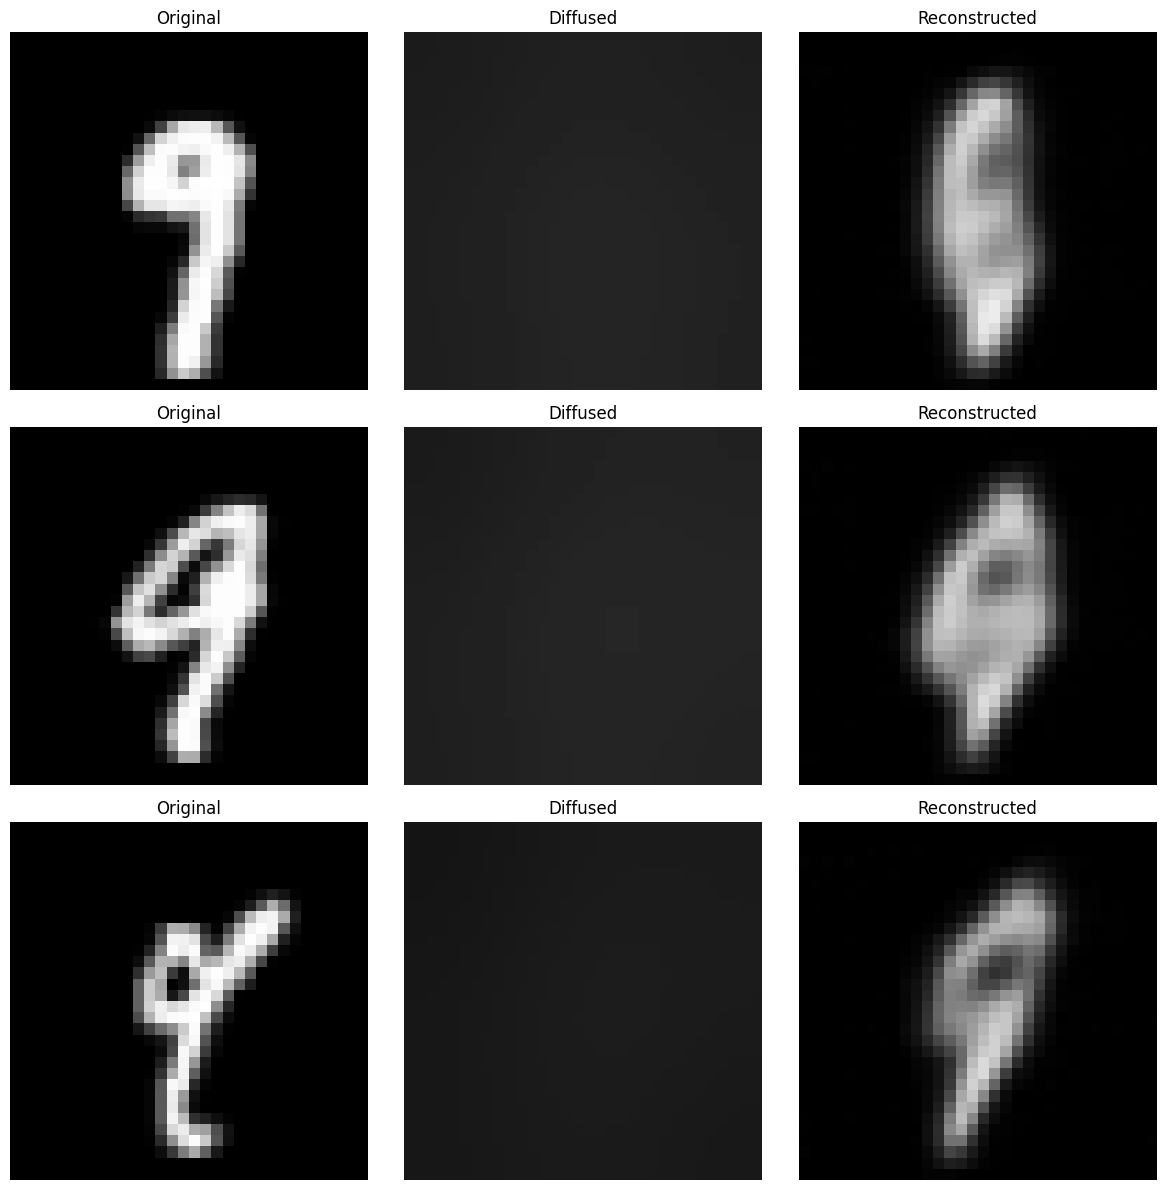

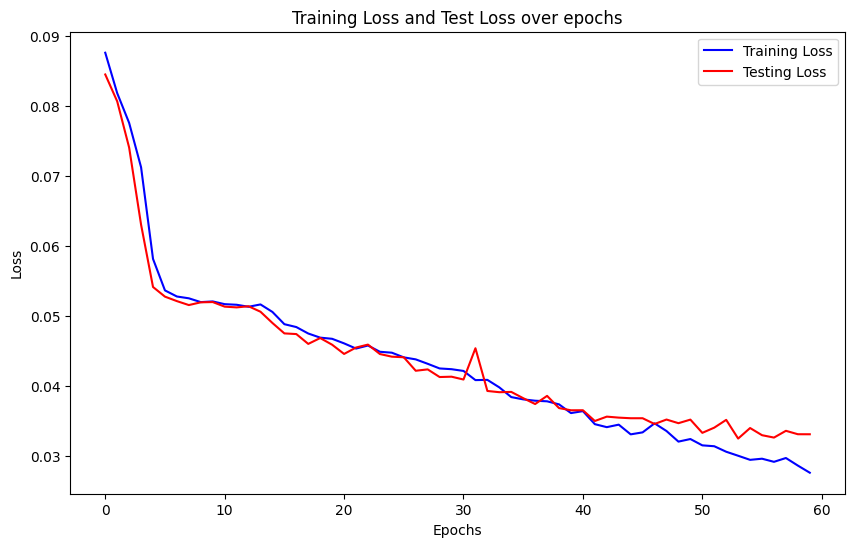

In [15]:
# Define the model, loss function and optimizer
model = U_net1().to(device) 
fem_solver = QuadElementFEM(nx=31, ny=31, Lx=1.0, Ly=1.0)         
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) 

# Create consistent diffusion by going from tensor to numpy, diffuse and back to tensor 
def diffuse_batch_fem(image_batch, fem_solver, dt, n_steps, diffusion_coeff):
    """Apply diffusion to a batch of images using FEM"""
    batch_size = image_batch.shape[0]
    diffused_batch = []
    for i in range(batch_size): 
        img_np = image_batch[i].squeeze().cpu().numpy() # Convert to numpy and remove channel dimension 
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min()) # Normalize to [0,1]
        if img_np.shape != (32, 32): 
            img_np = img_np.reshape(32, 32)
        u0 = img_np.flatten() 
        if len(u0) > fem_solver.n_nodes:
            u0 = u0[:fem_solver.n_nodes]
        elif len(u0) < fem_solver.n_nodes:
            u0 = np.pad(u0, (0, fem_solver.n_nodes - len(u0)))
        diffused_results = fem_solver.diffuse(u0, dt, n_steps, diffusion_coeff)
        diffused_img = diffused_results[-1] # We are only interested in the final result 
        diffused_tensor = torch.from_numpy(diffused_img).float().unsqueeze(0)
        diffused_batch.append(diffused_tensor)
    
    results = torch.stack(diffused_batch).to(image_batch.device)

    if torch.cuda.is_available(): 
        torch.cuda.empty_cache()
    return results

dt = 0.1
n_steps = 10
diffusion_coeff = 0.1

# Create a function for the training loop 

def train_loop(num_epochs, model, balanced_dataloader, balanced_test_dataloader, loss_fn, optimizer, fem_solver, dt, n_steps, diffusion_coeff):
    train_losses = []
    test_losses = []
    epochs = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch, (X, y) in enumerate(balanced_dataloader): # This means the batch is the index of the batch, while (X,y) is the actual data
            X, y = X.to(device), y.to(device)
            X_noisy = diffuse_batch_fem(X, fem_solver, dt, n_steps, diffusion_coeff)
            # Forward pass
            pred = model(X_noisy)
            loss = loss_fn(pred, X) # We want to reconstruct the original image
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if batch % 20 == 0: 
                print(f"Batch:{batch}, Loss: {loss.item():.4f}")
                # Debug: check value ranges
                print(f"  X range: [{X.min():.3f}, {X.max():.3f}]")
                print(f"  X_noisy range: [{X_noisy.min():.3f}, {X_noisy.max():.3f}]")
                print(f"  Pred range: [{pred.min():.3f}, {pred.max():.3f}]")
        
        train_loss /= len(balanced_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")
        train_losses.append(train_loss)

        model.eval() 
        with torch.no_grad(): 
            test_loss = 0 
            for X,y in balanced_test_dataloader: 
                X, y = X.to(device), y.to(device)
                X_noisy = diffuse_batch_fem(X, fem_solver, dt, n_steps, diffusion_coeff)
                
                pred = model(X_noisy)
                loss = loss_fn(pred, X)
                test_loss += loss.item() 


            test_loss /= len(balanced_test_dataloader)
            print(f"Test Loss: {test_loss:.4f}")
            test_losses.append(test_loss) 
            epochs.append(epoch)

    plot_comparison(X, X_noisy, pred, num_images = 3)
    return train_losses, test_losses


def plot_comparison(X, X_noisy, pred, num_images=3):
    """Comparison plot"""
    fig, axes = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))
    
    if num_images == 1: 
        axes = axes.reshape(1, -1)
     
    titles = ["Original", "Diffused", "Reconstructed"]
    
    for i in range(num_images): 
        orig_img = X[i].cpu().squeeze()
        noisy_img = X_noisy[i].cpu().squeeze()
        pred_img = pred[i].cpu().squeeze() 

        axes[i,0].imshow(orig_img, cmap='gray', vmin=0, vmax=1)
        axes[i,1].imshow(noisy_img, cmap='gray', vmin=0, vmax=1)
        axes[i,2].imshow(pred_img, cmap='gray', vmin=0, vmax=1)

        axes[i,0].set_title(f"{titles[0]}")
        axes[i,1].set_title(f"{titles[1]}")
        axes[i,2].set_title(f"{titles[2]}")

        for j in  range(3): 
            axes[i,j].axis('off')
    plt.tight_layout() 
    plt.show()

train_losses, test_losses = train_loop(num_epochs=60, model=model, balanced_dataloader=balanced_dataloader, balanced_test_dataloader=balanced_test_dataloader, loss_fn=loss_fn, optimizer=optimizer, fem_solver=fem_solver, dt=dt, n_steps=n_steps, diffusion_coeff=diffusion_coeff)

#torch.save(model.state_dict(), "unet1_mnist.pth")


def plot_losses(train_losses, test_losses): 
    plt.figure(figsize=(10,6))
    
    plt.plot(train_losses, label='Training Loss', color = 'blue')
    plt.plot(test_losses, label='Testing Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss and Test Loss over epochs')
    plt.legend()
    plt.show() 

plot_losses(train_losses, test_losses)

# 4. Improvements to the Network

In this section, we look at methods to improve the network. This will include using different optimizers, prediffusing the whole dataset to increase training speed, adding batch normalization, adding weight decay, and adding a learning rate scheduler.

## 4.1 Prediffuse 

In this section, we diffuse the whole dataset before feeding it into the neural network. 

In [ ]:
# Pre-diffuse the entire dataset and save it 
def precompute_diffused_dataset(dataloader, fem_solver, dt, n_steps, diffusion_coeff, save_path): 
    all_diffused = []
    all_original = []
    all_labels = [] 
    for batch, (X,y) in enumerate(dataloader): 
        print(f"Precomputing batch {batch}/{len(dataloader)}")
        X_diffused = diffuse_batch_fem(X, fem_solver, dt, n_steps, diffusion_coeff)
        all_diffused.append(X_diffused.cpu())
        all_original.append(X.cpu()) 
        all_labels.append(y.cpu())
    
    diffused_tensor = torch.cat(all_diffused)
    original_tensor = torch.cat(all_original)
    labels_tensor = torch.cat(all_labels)
    
    torch.save({'diffused': diffused_tensor, 
                'original': original_tensor, 
                'labels': labels_tensor}, save_path)
    return diffused_tensor, original_tensor, labels_tensor
    
class PrecomputedDataset(Dataset): 
    def  __init__(self, data_path): 
        data = torch.load(data_path)
        self.diffused = data['diffused']
        self.original = data['original']
        self.labels = data['labels']

        #print(f"Initial shapes - Diffused: {self.diffused.shape}, Original: {self.original.shape}")

        if self.diffused.dim() == 3: 
            self.diffused = self.diffused.unsqueeze(1)
        if self.original.dim() == 3:
            self.original = self.original.unsqueeze(1)
            
        #print(f"Final shapes - Diffused: {self.diffused.shape}, Original: {self.original.shape}")
        
        # Verify data ranges
        #print(f"Value ranges - Original: [{self.original.min():.3f}, {self.original.max():.3f}]")
        #print(f"Value ranges - Diffused: [{self.diffused.min():.3f}, {self.diffused.max():.3f}]")

        # Normalize if needed
        self._normalize_data()
    
    def _normalize_data(self):
        """Normalize data to [0, 1] range if needed"""
        if self.original.max() > 1.0 or self.original.min() < 0.0:
            self.original = (self.original - self.original.min()) / (self.original.max() - self.original.min())
            print("Normalized original images to [0, 1]")
        
        if self.diffused.max() > 1.0 or self.diffused.min() < 0.0:
            self.diffused = (self.diffused - self.diffused.min()) / (self.diffused.max() - self.diffused.min())
            print("Normalized diffused images to [0, 1]")
    
    def __len__(self): 
        return len(self.diffused)
    
    def __getitem__(self, idx): 
        return self.diffused[idx], self.original[idx], self.labels[idx]

# Run precomputation for the diffusion of the images 

def run_precomputation(): 
    train_data, test_data, train_dataloader, test_dataloader, BATCH_SIZE = mnist_data_loader() 

    fem_solver = QuadElementFEM(nx=31, ny=31, Lx=1.0, Ly=1.0)

    dt = 0.1
    n_steps = 10 
    diffusion_coeff = 0.1

    print("Precomputing training dataset")
    precompute_diffused_dataset(train_dataloader, fem_solver, dt, n_steps, diffusion_coeff, "mnist_train_diffused.pth")

    print("Precomputing test dataset")
    precompute_diffused_dataset(test_dataloader, fem_solver, dt, n_steps, diffusion_coeff, "mnist_test_diffused.pth")


## 4.2 The Improved U-Net

In this part we have added batch normalization to the convolutional block and dropout to the encoder path.

In [45]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),                                   
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x): 
        return self.conv(x)

class U_net2(nn.Module):                                                        # We want to improve the U-net by adding regularization 
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128, 256]): 
        super().__init__()
        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(0.2)                                          # Added dropout for regualarization 

        # Encoder part  

        for feature in features: 
            self.encoder.append(ConvBlock(in_channels, feature))
            in_channels = feature
            
        # Bottleneck part 
        self.bottleneck = ConvBlock(features[-1], features[-1]*2)

        # Decoder part 
        self.upconvs = nn.ModuleList()
        self.decoder = nn.ModuleList()

        reversed_features = features[::-1]
        for feature in reversed_features: 
            self.upconvs.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.decoder.append(ConvBlock(feature*2, feature))
        
        # Final convolution 
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x): 
        skip_connections = []
        for encode in self.encoder: 
            x = encode(x)
            skip_connections.append(x)
            x = self.pool(x)
            x = self.dropout(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(len(self.upconvs)): 
            x = self.upconvs[idx](x)
            skip_connection = skip_connections[idx]
            if x.shape != skip_connection.shape: 
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True) # We resize x to have the same shape as skip_connection as this is more common in concatenation skip connections
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx](concat_skip)
        return self.final_conv(x) 

## 4.3 The Improved Training and Testing Loop



In [ ]:
def train_loop_precomputed(num_epochs, model, train_loader, test_loader, loss_fn, optimizer, scheduler, device): 
    model.to(device)
    train_losses = []
    test_losses = []
    epochs = []
    for epoch in range(num_epochs): 
        train_loss = 0.0
        model.train() 
        
        for batch, (X_noisy, X_clean, y) in enumerate(train_loader): 
            X_noisy, X_clean = X_noisy.to(device), X_clean.to(device)

            pred = model(X_noisy)
            loss = loss_fn(pred, X_clean) 

            optimizer.zero_grad() 
            loss.backward() 

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step() 

            train_loss += loss.item() 

            if batch % 100 == 0: 
                print(f"Epoch:{epoch+1}, batch: {batch}, Loss: {loss.item():.4f}")

        train_loss /= len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")

        train_losses.append(train_loss)

        model.eval() 
        test_loss = 0 
        
        with torch.no_grad(): 
            for X_noisy, X_clean, y in test_loader: 
                X_noisy, X_clean = X_noisy.to(device), X_clean.to(device)

                pred = model(X_noisy)
                loss = loss_fn(pred, X_clean)
                test_loss += loss.item() 
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        scheduler.step(test_loss)
        epochs.append(epoch)
        print(f"Test Loss: {test_loss:.4f}")

    plot_comparison_precomputed(X_clean, X_noisy, pred)

    %torch.save(model.state_dict(), "unet2_mnist_best_model_10_epochs.pth")
    print("Training completed!")
    return train_losses, test_losses

def test_loop_precomputed(model, test_loader, loss_fn, device): 
    model.eval() 
    test_loss = 0 
    test_losses = []
    with torch.no_grad(): 
        for X_noisy, X_clean, y in test_loader: 
            X_noisy, X_clean = X_noisy.to(device), X_clean.to(device)

            pred = model(X_noisy)
            loss = loss_fn(pred, X_clean)
            test_loss += loss.item() 
    
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    print(f"Test Loss: {test_loss:.4f}")

    plot_comparison_precomputed(X_clean, X_noisy, pred)
    return test_losses

def plot_comparison_precomputed(clean, noisy, pred, num_images=3): 
    fig, axes = plt.subplots(num_images, 3, figsize=(12, 4*num_images))

    if num_images ==1: 
        axes = axes.reshape(1, -1)

    for i in range(num_images): 
        axes[i,0].imshow(clean[i].cpu().squeeze(), cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i,0].axis('off')

        axes[i,1].imshow(noisy[i].cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[i,1].set_title('Diffused')
        axes[i,1].axis('off')

        axes[i,2].imshow(pred[i].cpu().squeeze(), cmap='gray')
        axes[i,2].set_title('Reconstructed')
        axes[i,2].axis('off')

    plt.tight_layout() 
    plt.show() 

def plot_losses(train_losses, test_losses): 
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label='Training Loss', color = 'blue')
    plt.plot(test_losses, label='Testing Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss and Test Loss over epochs')
    plt.legend()
    plt.show() 
    

To run the training process we use the following cell, in this cell we can easily test different numbers of epochs, batch sizes, learning rates, 

Final shapes - Diffused: torch.Size([60000, 1, 32, 32]), Original: torch.Size([60000, 1, 32, 32])
Value ranges - Original: [0.000, 1.000]
Value ranges - Diffused: [0.024, 0.462]
Final shapes - Diffused: torch.Size([10000, 1, 32, 32]), Original: torch.Size([10000, 1, 32, 32])
Value ranges - Original: [0.000, 1.000]
Value ranges - Diffused: [0.026, 0.375]
Epoch:1, batch: 0, Loss: 0.3847
Epoch:1, batch: 100, Loss: 0.0534
Epoch:1, batch: 200, Loss: 0.0438
Epoch:1, batch: 300, Loss: 0.0426
Epoch:1, batch: 400, Loss: 0.0414
Epoch:1, batch: 500, Loss: 0.0387
Epoch:1, batch: 600, Loss: 0.0425
Epoch:1, batch: 700, Loss: 0.0359
Epoch:1, batch: 800, Loss: 0.0330
Epoch:1, batch: 900, Loss: 0.0365
Epoch:1, batch: 1000, Loss: 0.0346
Epoch:1, batch: 1100, Loss: 0.0289
Epoch:1, batch: 1200, Loss: 0.0303
Epoch:1, batch: 1300, Loss: 0.0298
Epoch:1, batch: 1400, Loss: 0.0293
Epoch:1, batch: 1500, Loss: 0.0285
Epoch:1, batch: 1600, Loss: 0.0269
Epoch:1, batch: 1700, Loss: 0.0278
Epoch:1, batch: 1800, Loss

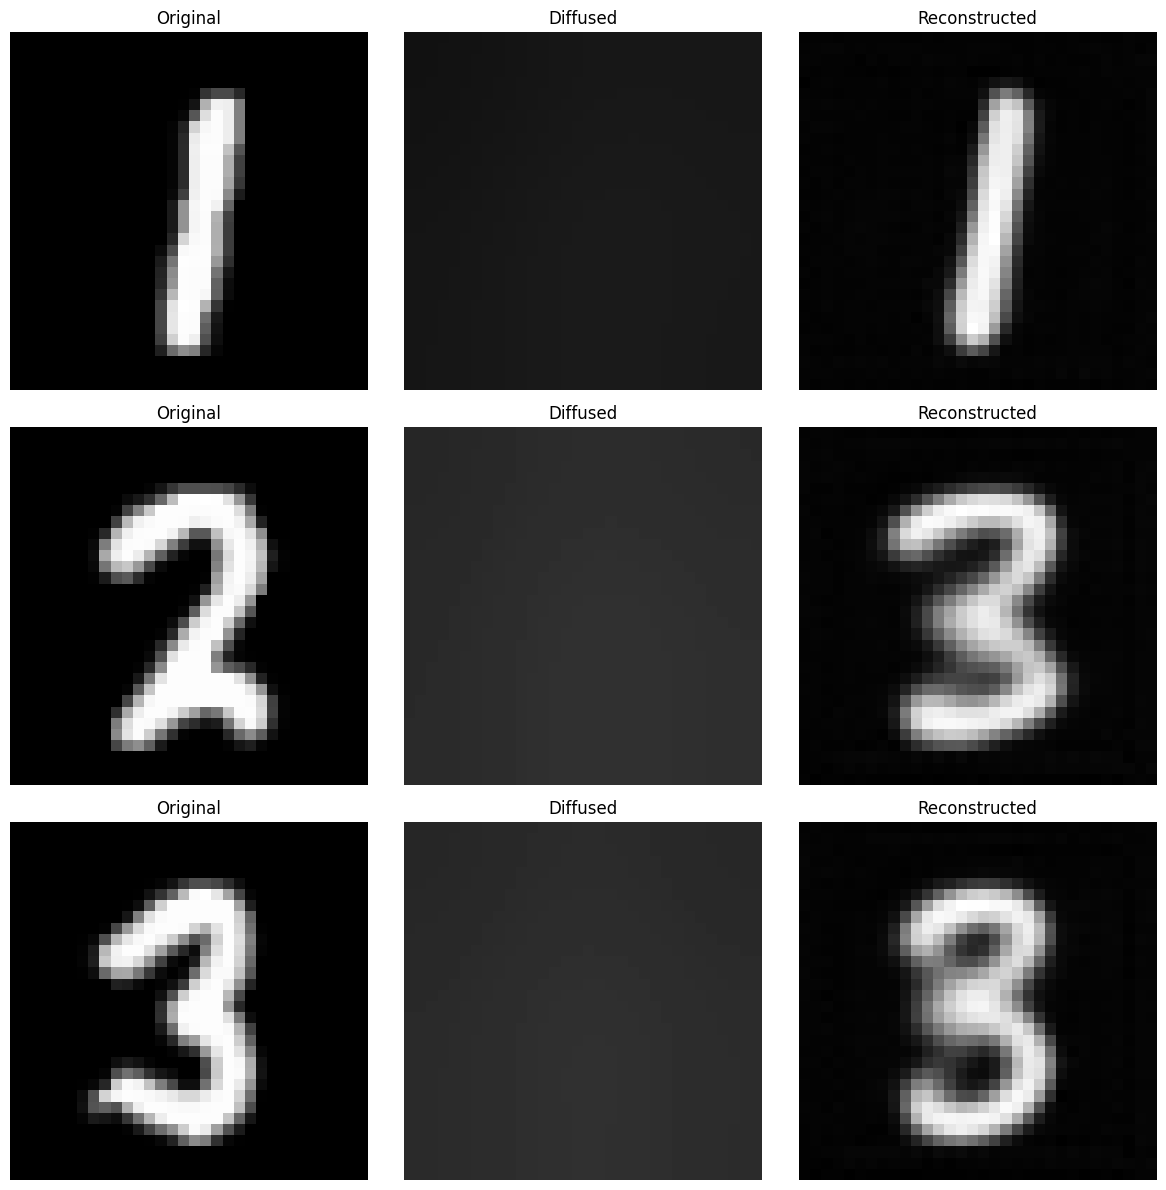

Training completed!


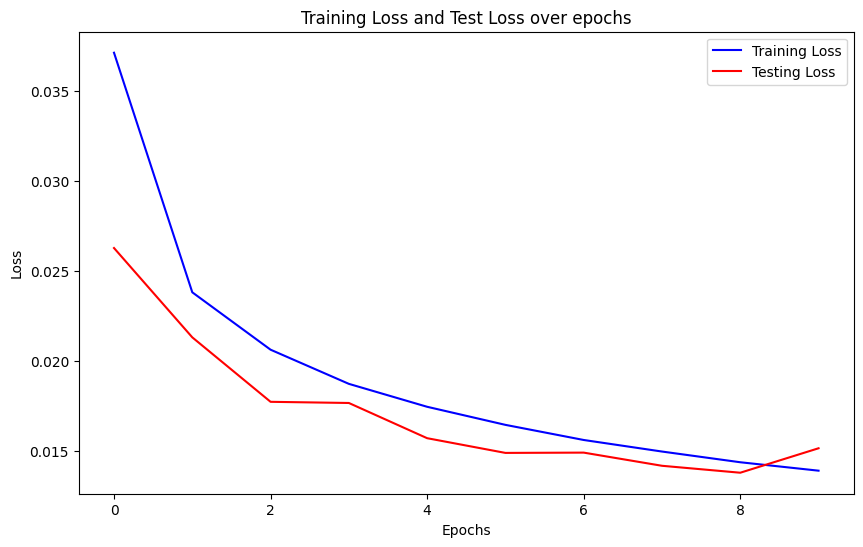

Total runtime: 665.85 seconds


In [54]:
def train_with_precomputed(num_epoch, BATCH_SIZE = 32): 
    # Load precomputed datasets 
    train_dataset = PrecomputedDataset("mnist_train_diffused.pth")
    test_dataset = PrecomputedDataset("mnist_test_diffused.pth")

    # Create dataloaders 
    BATCH_SIZE = BATCH_SIZE
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = False)

    # Model and optimizer 
    model = U_net2().to(device)
    optimizer = optim.AdamW(model.parameters(), lr = 1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, eps=1e-10)
    loss_fn = nn.MSELoss() 

    train_losses, test_losses = train_loop_precomputed(num_epochs=num_epoch, model=model, train_loader=train_loader, test_loader=test_loader, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, device=device)
 
    plot_losses(train_losses, test_losses)
start_time = time.time()
train_with_precomputed(10)
end_time = time.time()

print(f"Total runtime: {end_time-start_time:.2f} seconds")

In the next part of code, we want to compare the improved network, and training and testing loop on the balanced subset, so we can see if there is an improvement. The improvement could namely also be from the fact that we use a bigger dataset. 

Batch:0, Loss: 0.2225
Epoch 1/10, Training Loss: 0.1064
Test Loss: 0.1017
Batch:0, Loss: 0.0664
Epoch 2/10, Training Loss: 0.0635
Test Loss: 0.0839
Batch:0, Loss: 0.0631
Epoch 3/10, Training Loss: 0.0574
Test Loss: 0.0758
Batch:0, Loss: 0.0551
Epoch 4/10, Training Loss: 0.0544
Test Loss: 0.0602
Batch:0, Loss: 0.0514
Epoch 5/10, Training Loss: 0.0529
Test Loss: 0.0534
Batch:0, Loss: 0.0485
Epoch 6/10, Training Loss: 0.0519
Test Loss: 0.0499
Batch:0, Loss: 0.0528
Epoch 7/10, Training Loss: 0.0515
Test Loss: 0.0494
Batch:0, Loss: 0.0522
Epoch 8/10, Training Loss: 0.0507
Test Loss: 0.0485
Batch:0, Loss: 0.0515
Epoch 9/10, Training Loss: 0.0501
Test Loss: 0.0478
Batch:0, Loss: 0.0477
Epoch 10/10, Training Loss: 0.0498
Test Loss: 0.0477


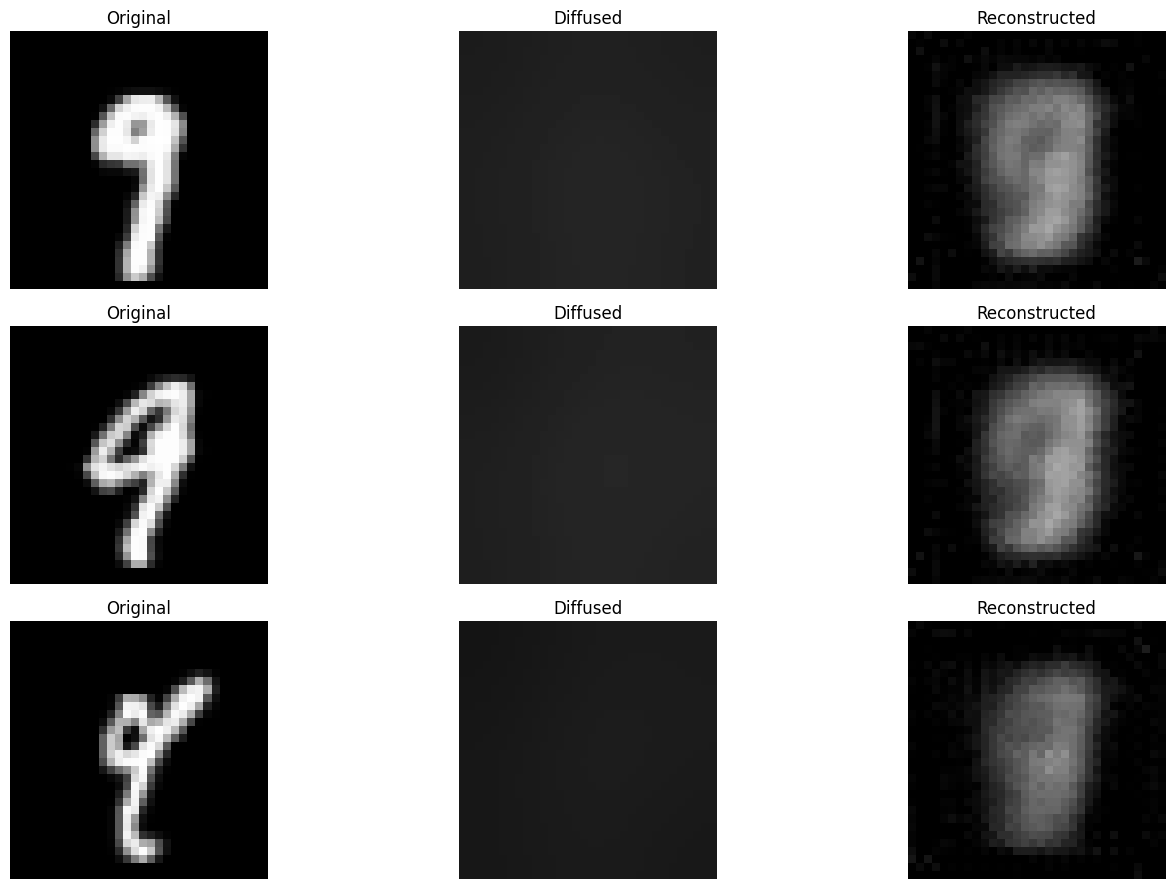

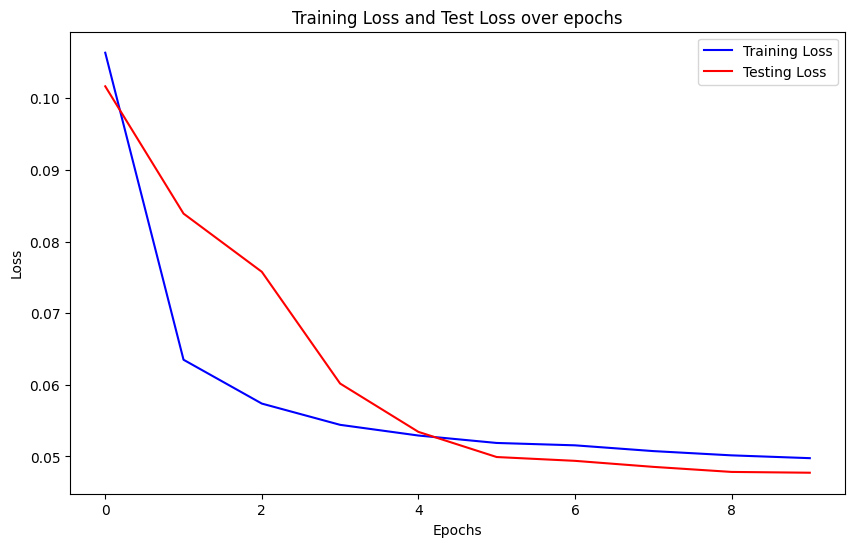

In [ ]:
# Define the model, loss function and optimizer
model = U_net2().to(device) 
fem_solver = QuadElementFEM(nx=31, ny=31, Lx=1.0, Ly=1.0)         
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.1)

# Create consistent diffusion by going from tensor to numpy, diffuse and back to tensor 
def diffuse_batch_fem(image_batch, fem_solver, dt, n_steps, diffusion_coeff):
    """Apply diffusion to a batch of images using FEM"""
    batch_size = image_batch.shape[0]
    diffused_batch = []
    for i in range(batch_size): 
        img_np = image_batch[i].squeeze().cpu().numpy() # Convert to numpy and remove channel dimension 
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min()) # Normalize to [0,1]
        if img_np.shape != (32, 32): 
            img_np = img_np.reshape(32, 32)
        u0 = img_np.flatten() 
        if len(u0) > fem_solver.n_nodes:
            u0 = u0[:fem_solver.n_nodes]
        elif len(u0) < fem_solver.n_nodes:
            u0 = np.pad(u0, (0, fem_solver.n_nodes - len(u0)))
        diffused_results = fem_solver.diffuse(u0, dt, n_steps, diffusion_coeff)
        diffused_img = diffused_results[-1] # We are only interested in the final result 
        diffused_tensor = torch.from_numpy(diffused_img).float().unsqueeze(0)
        diffused_batch.append(diffused_tensor)
    
    results = torch.stack(diffused_batch).to(image_batch.device)

    if torch.cuda.is_available(): 
        torch.cuda.empty_cache()
    return results

dt = 0.1
n_steps = 10
diffusion_coeff = 0.1

# Create a function for the training loop 

def train_loop(num_epochs, model, balanced_dataloader, balanced_test_dataloader, loss_fn, optimizer, fem_solver, dt, n_steps, diffusion_coeff, scheduler):
    train_losses = []
    test_losses = []
    epochs = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch, (X, y) in enumerate(balanced_dataloader): # This means the batch is the index of the batch, while (X,y) is the actual data
            X, y = X.to(device), y.to(device)
            X_noisy = diffuse_batch_fem(X, fem_solver, dt, n_steps, diffusion_coeff)
            # Forward pass
            pred = model(X_noisy)
            loss = loss_fn(pred, X) # We want to reconstruct the original image
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

            if batch % 20 == 0: 
                print(f"Batch:{batch}, Loss: {loss.item():.4f}")
        
        train_loss /= len(balanced_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")
        train_losses.append(train_loss)

        model.eval() 
        with torch.no_grad(): 
            test_loss = 0 
            for X,y in balanced_test_dataloader: 
                X, y = X.to(device), y.to(device)
                X_noisy = diffuse_batch_fem(X, fem_solver, dt, n_steps, diffusion_coeff)
                pred = model(X_noisy)
                loss = loss_fn(pred, X)
                test_loss += loss.item() 


            test_loss /= len(balanced_test_dataloader)
            print(f"Test Loss: {test_loss:.4f}")
            scheduler.step(test_loss)
            test_losses.append(test_loss) 
            epochs.append(epoch)

    plot_comparison(X, X_noisy, pred, num_images = 3)
    return train_losses, test_losses


def plot_comparison(X, X_noisy, pred, num_images=3):
    """Comparison plot"""
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 3 * num_images))
    
    if num_images == 1: 
        axes = axes.reshape(1, -1)
     
    titles = ["Original", "Diffused", "Reconstructed"]
    
    for i in range(num_images): 
        orig_img = X[i].cpu().squeeze()
        noisy_img = X_noisy[i].cpu().squeeze()
        pred_img = pred[i].cpu().squeeze() 

        axes[i,0].imshow(orig_img, cmap='gray', vmin=0, vmax=1)
        axes[i,1].imshow(noisy_img, cmap='gray', vmin=0, vmax=1)
        axes[i,2].imshow(pred_img, cmap='gray', vmin=0, vmax=1)

        axes[i,0].set_title(f"{titles[0]}")
        axes[i,1].set_title(f"{titles[1]}")
        axes[i,2].set_title(f"{titles[2]}")

        for j in  range(3): 
            axes[i,j].axis('off')
    plt.tight_layout() 
    plt.show()


train_losses, test_losses = train_loop(num_epochs=10, model=model, balanced_dataloader=balanced_dataloader, balanced_test_dataloader=balanced_test_dataloader, loss_fn=loss_fn, optimizer=optimizer, fem_solver=fem_solver, dt=dt, n_steps=n_steps, diffusion_coeff=diffusion_coeff, scheduler=scheduler)

def plot_losses(train_losses, test_losses): 
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label='Training Loss', color = 'blue')
    plt.plot(test_losses, label='Testing Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss and Test Loss over epochs')
    plt.legend()
    plt.show() 

plot_losses(train_losses, test_losses)

# 5 Using the network on random data 

In this part, we will test the model on random data. There are several ways to create this data. 

## 5.1 Interpolating within the dataset.
In the first method we interpolate two images from the diffused dataset. 

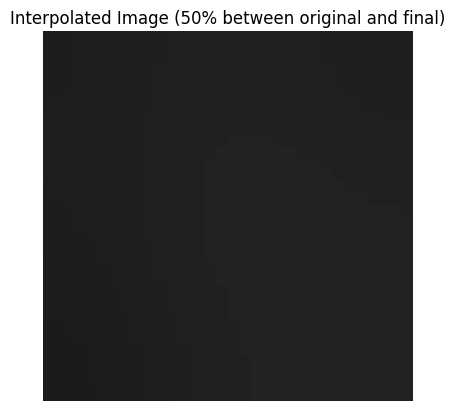

In [81]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

from PIL import Image

def create_interpolated_image(saved_filepath, alpha=0.5):
    """
    Create a new image by interpolating between two time steps
    alpha=0: first image, alpha=1: last image
    """
    checkpoint = torch.load(saved_filepath)
    results = checkpoint['diffused'].numpy().squeeze()
    
    # Linear interpolation between first and last image
    new_image = (1 - alpha) * results[0] + alpha * results[-1]
    
    return new_image

# Usage
filepath = "mnist_train_diffused.pth"
new_image = create_interpolated_image(filepath, alpha=0.5)
plt.imshow(new_image, cmap='gray', vmin=0, vmax=1)
plt.title("Interpolated Image (50% between original and final)")
plt.axis('off')
plt.show()


new_image = (new_image * 255).astype('uint8')
new_image = Image.fromarray(new_image)

new_image.save('interpolated_gray.png')

## 5.2 Random data with the same distribution
In this method we create a random image with the same distribution as the MNIST dataset. Then we use the finite element method to diffuse this image. 

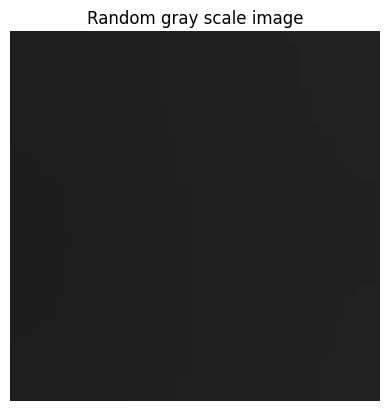

In [82]:
from PIL import Image
def create_diffused_from_random_initial(fem_solver, diffusion_time=10, image_shape=(32, 32), mean = 0.1307, std = 0.3081):
    """
    Start with random noise and diffuse it completely
    """
    # Create random initial condition
    random_initial = torch.randn(1, 1, *image_shape) * std + mean  # Roughly MNIST distribution

    random_initial = random_initial.numpy().flatten()
    
    # Diffuse for long time
    completely_diffused = fem_solver.diffuse(random_initial, dt = 0.1, n_steps = diffusion_time, diffusion_coeff= 0.1)
    final_diffused = completely_diffused[-1].reshape(image_shape)
    
    return final_diffused, random_initial.squeeze()

# Usage 
diffused_image, random_initial = create_diffused_from_random_initial(fem_solver, diffusion_time=10, image_shape=(32, 32), mean = 0.1307, std = 0.3081)

plt.imshow(diffused_image, cmap='gray', vmin=0, vmax=1)
plt.title("Random gray scale image")
plt.axis('off')

diffused_image = (diffused_image * 255).astype('uint8')

diffused_image = Image.fromarray(diffused_image)

diffused_image.save('random_gray_image.png')

## 5.3 Use network to reconstruct these images
In this section we will use the network created to reconstruct the images. 

<function matplotlib.pyplot.show(close=None, block=None)>

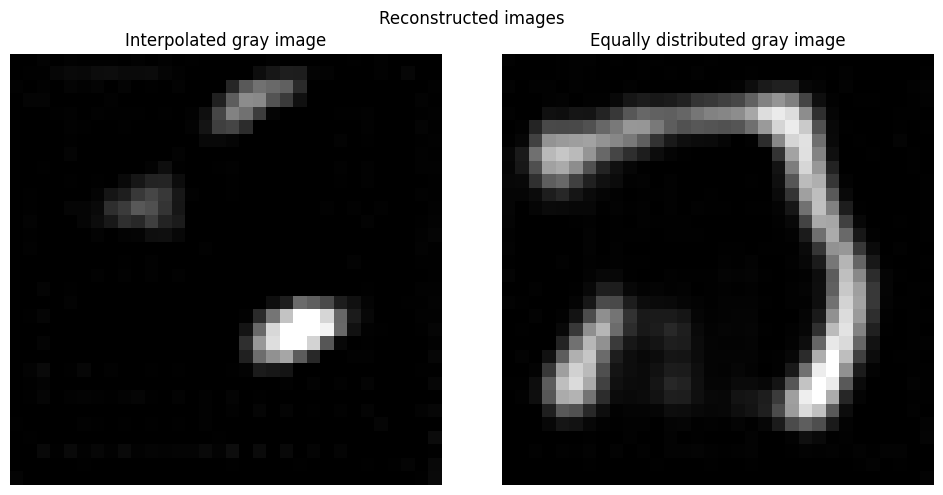

In [98]:
from PIL import Image 
import torch 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# We first load in the gray scale images that we saved. 
interpolated_gray= Image.open('interpolated_gray.png')
distributed_gray = Image.open('random_gray_image.png')
data_transformer = transforms.Compose([transforms.Resize(size=(32, 32)), transforms.ToTensor()])
interpolated_gray_transformed = data_transformer(interpolated_gray).unsqueeze(0).to(device)
distributed_gray_transformed = data_transformer(distributed_gray).unsqueeze(0).to(device)

#Load in the model's pretrained weights
model_ = U_net2()
model.load_state_dict(torch.load('unet2_mnist_best_model_10_epochs.pth', weights_only=True))
model.eval() 

pred_interpolated_gray = model(interpolated_gray_transformed)
pred_distributed_gray = model(distributed_gray_transformed)

pred_interpolated_gray = pred_interpolated_gray.squeeze().squeeze()
pred_interpolated_gray = pred_interpolated_gray.detach().cpu().numpy()
pred_distributed_gray = pred_distributed_gray.squeeze().squeeze() 
pred_distributed_gray = pred_distributed_gray.detach().cpu().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(pred_interpolated_gray, cmap='gray', vmin=0, vmax=1)
axs[0].set_title("Interpolated gray image")
axs[1].imshow(pred_distributed_gray, cmap='gray', vmin=0, vmax=1)
axs[1].set_title("Equally distributed gray image")
plt.axis('off')

for ax in axs.ravel():
    ax.set_axis_off()

fig.suptitle('Reconstructed images' )
plt.tight_layout()
plt.show
